In [1]:
from scipy import misc, ndimage, signal
from sklearn.model_selection  import train_test_split
import numpy
import numpy as np
import random
import ntpath
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import tensorflow as tf
from tensorflow.keras import optimizers 
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from time import time
import time as tm
import datetime
from operator import itemgetter
import glob
from tensorflow.keras.utils import *
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.utils
from numpy import argmax
import seaborn as sn 

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
X = np.load('../InpactorDB/version_final/InpactorDB_non-redudant.fasta.filtered_kmers.npy').astype(np.int16)
Y = np.load('../InpactorDB/version_final/InpactorDB_non-redudant.fasta.filtered_kmers_labels.npy').astype(np.int16)

In [4]:
print(X.shape)
print(Y.shape)

type(X[0, 0, 0])

(67305, 256, 256)
(67305, 1)


numpy.int16

In [5]:
#data split: 80% train, 10% dev and 10% test
validation_size = 0.2
seed = 7
X_train, X_test_dev, Y_train, Y_test_dev = train_test_split(X, Y, test_size=validation_size, random_state=seed)

X_dev, X_test, Y_dev, Y_test = train_test_split(X_test_dev, Y_test_dev, test_size=0.5, random_state=seed)

print(X_train.shape)
print(Y_train.shape)
print(X_dev.shape)
print(Y_dev.shape)
print(X_test.shape)
print(Y_test.shape)

(53844, 256, 256)
(53844, 1)
(6730, 256, 256)
(6730, 1)
(6731, 256, 256)
(6731, 1)


In [6]:
X = None
Y = None
path_log_base = './logs_CNN'

In [7]:
def metrics(Y_validation,predictions):
    
    classes = len(numpy.unique(Y_validation))
    print('Accuracy:', accuracy_score(Y_validation, predictions))
    print('F1 score:', f1_score(Y_validation, predictions,average='weighted'))
    print('Recall:', recall_score(Y_validation, predictions,average='weighted'))
    print('Precision:', precision_score(Y_validation, predictions, average='weighted'))
    print('\n clasification report:\n', classification_report(Y_validation, predictions))
    print('\n confusion matrix:\n',confusion_matrix(Y_validation, predictions))
    #Creamos la matriz de confusión
    snn_cm = confusion_matrix(Y_validation, predictions)

    # Visualizamos la matriz de confusión
    snn_df_cm = pd.DataFrame(snn_cm, range(classes), range(classes))  
    plt.figure(figsize = (20,14))  
    sn.set(font_scale=1.4) #for label size  
    sn.heatmap(snn_df_cm, annot=True, annot_kws={"size": 12}) # font size  
    plt.show()

In [8]:
def train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size, epochs, model_name=""):
    start_time = tm.time()
    log_dir=path_log_base+"/"+model_name+"_"+str(datetime.datetime.now().isoformat()[:19].replace("T", "_").replace(":","-"))
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)
    filepath = log_dir+"/saved-model-{epoch:03d}-{val_f1_m:.4f}.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_f1_m', save_best_only=False, mode='max')
    model.reset_states()
    
    #VALORES EN TRAIN TEST Y VALIDACIÓN INICIALES, GRÁFICOS
    global lossTEST
    global accuracyTEST
    global lossTRAIN
    global accuracyTRAIN
    global lossVALID
    global accuracyVALID
    lossTEST,accuracyTEST   = model.evaluate(X_test, y_test,verbose=None)
    lossTRAIN,accuracyTRAIN = model.evaluate(X_train, y_train,verbose=None)
    lossVALID,accuracyVALID = model.evaluate(X_valid, y_valid,verbose=None)

    global history
    global model_Name
    global log_Dir
    model_Name = model_name
    log_Dir = log_dir
    
    history=model.fit(X_train, y_train, epochs=epochs, 
                      callbacks=[tensorboard,checkpoint], 
                      batch_size=batch_size,validation_data=(X_valid, y_valid),verbose=1)
    
    metrics = model.evaluate(X_test, y_test, verbose=0)
     
    TIME = tm.time() - start_time
    print("Time "+model_name+" = %s [seconds]" % TIME)
    
    print("\n")
    print(log_dir)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [9]:
def Final_Results_Test(PATH_trained_models):
    global AccTest
    global LossTest
    AccTest = []
    LossTest= [] 
    B_accuracy = 0 #B --> Best
    for filename in sorted(os.listdir(PATH_trained_models)):
        if filename != ('train') and filename != ('validation'):
            print(filename)
            model = tf.keras.models.load_model(PATH_trained_models+'/'+filename, custom_objects={'f1_m':f1_m})
            loss,accuracy = model.evaluate(X_test, y_test,verbose=0)
            print(f'Loss={loss:.4f} y F1-Score={accuracy:0.4f}'+'\n')
            BandAccTest  = accuracy
            BandLossTest = loss
            AccTest.append(BandAccTest)    #Valores de la precisión en Test, para graficar junto a valid y train
            LossTest.append(BandLossTest)  #Valores de la perdida en Test, para graficar junto a valid y train
            
            if accuracy > B_accuracy:
                B_accuracy = accuracy
                B_loss = loss
                B_name = filename
    
    print("\n\nBest")
    print(B_name)
    print(f'Loss={B_loss:.4f} y F1-Score={B_accuracy:0.4f}'+'\n')

In [10]:
def graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID):
    numbers=AccTest
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Test F1-Score {}, Época:{}\n".format(value, index+1))
    
    print("")
    
    numbers=history.history['f1_m']
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Train F1-Score {}, Época:{}\n".format(value, index+1))
    
    print("")
    
    numbers=history.history['val_f1_m']
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Validation F1-Score {}, Época:{}\n".format(value, index+1))

    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(10, 10))
        #Plot training & validation accuracy values
        plt.plot(np.concatenate([np.array([accuracyTRAIN]),np.array(history.history['f1_m'])],axis=0))
        plt.plot(np.concatenate([np.array([accuracyVALID]),np.array(history.history['val_f1_m'])],axis=0))
        plt.plot(np.concatenate([np.array([accuracyTEST]),np.array(AccTest)],axis=0)) #Test
        plt.title('F1-Score Vs Epoch')
        plt.ylabel('F1-Score')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
        plt.grid('on')
        #plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.eps', format='eps')
        #plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.svg', format='svg')
        #plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.pdf', format='pdf')     
        #plt.show()
        
        plt.figure(figsize=(10, 10))
        #Plot training & validation loss values
        plt.plot(np.concatenate([np.array([lossTRAIN]),np.array(history.history['loss'])],axis=0))
        plt.plot(np.concatenate([np.array([lossVALID]),np.array(history.history['val_loss'])],axis=0))
        plt.plot(np.concatenate([np.array([lossTEST]),np.array(LossTest)],axis=0)) #Test
        plt.title('Loss Vs Epoch')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
        plt.grid('on')
        #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.eps', format='eps')
        #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.svg', format='svg')
        #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.pdf', format='pdf') 
        plt.show() 

In [11]:
def Final_Results_Test(PATH_trained_models):
    global AccTest
    global LossTest
    AccTest = []
    LossTest= [] 
    B_accuracy = 0 #B --> Best
    for filename in sorted(os.listdir(PATH_trained_models)):
        if filename != ('train') and filename != ('validation'):
            print(filename)
            model = tf.keras.models.load_model(PATH_trained_models+'/'+filename, custom_objects={'f1_m':f1_m})
            loss,accuracy = model.evaluate(X_test, one_hot_labels_test,verbose=0)
            print(f'Loss={loss:.4f} y F1-Score={accuracy:0.4f}'+'\n')
            BandAccTest  = accuracy
            BandLossTest = loss
            AccTest.append(BandAccTest)    #Valores de la precisión en Test, para graficar junto a valid y train
            LossTest.append(BandLossTest)  #Valores de la perdida en Test, para graficar junto a valid y train
            
            if accuracy > B_accuracy:
                B_accuracy = accuracy
                B_loss = loss
                B_name = filename
    
    print("\n\nBest")
    print(B_name)
    print(f'Loss={B_loss:.4f} y F1-Score={B_accuracy:0.4f}'+'\n')

In [12]:
def train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size, epochs, model_name=""):
    start_time = tm.time()
    log_dir=path_log_base+"/"+model_name+"_"+str(datetime.datetime.now().isoformat()[:19].replace("T", "_").replace(":","-"))
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)
    filepath = log_dir+"/saved-model-{epoch:03d}-{val_f1_m:.4f}.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_f1_m', save_best_only=False, mode='max')
    model.reset_states()
    
    #VALORES EN TRAIN TEST Y VALIDACIÓN INICIALES, GRÁFICOS
    global lossTEST
    global accuracyTEST
    global lossTRAIN
    global accuracyTRAIN
    global lossVALID
    global accuracyVALID
    lossTEST,accuracyTEST   = model.evaluate(X_test, y_test,verbose=None)
    lossVALID,accuracyVALID = model.evaluate(X_valid, y_valid,verbose=None)
    lossTRAIN,accuracyTRAIN = model.evaluate(X_train, y_train,verbose=None)
    
    global history
    global model_Name
    global log_Dir
    model_Name = model_name
    log_Dir = log_dir
    
    history=model.fit(X_train, y_train, epochs=epochs, 
                      callbacks=[tensorboard,checkpoint], 
                      batch_size=batch_size,validation_data=(X_valid, y_valid),verbose=1)
    
    metrics = model.evaluate(X_test, y_test, verbose=0)
     
    TIME = tm.time() - start_time
    print("Time "+model_name+" = %s [seconds]" % TIME)
    
    print("\n")
    print(log_dir)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [23]:
def TERL():
    tf.keras.backend.clear_session()

    # FNN implemented by Nakano

    # Inputs
    inputs = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2], 1), name="input_1")
    # layer 1
    layers = tf.keras.layers.Conv2D(64, (9, 9), strides=(3, 3), activation="relu", use_bias=True)(inputs)
    tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.AveragePooling2D((5,5), strides= (5,5))(layers)
    # layer 2
    layers = tf.keras.layers.Conv2D(32, (9, 9), strides=(3, 3), activation="relu", use_bias=True)(layers)
    tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #layers = tf.keras.layers.AveragePooling2D((5,5), strides= (5,5))(layers)
    # layer 3
    layers = tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), activation="relu", use_bias=True)(layers)
    #tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #layers = tf.keras.layers.AveragePooling2D((2,2), strides= (1,1))(layers)
    # layer 4
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(1000,activation="relu")(layers)
    layers = tf.keras.layers.Dense(500,activation="relu")(layers)
    # layer 5
    predictions = tf.keras.layers.Dense(21, activation="softmax", name="output_1")(layers)
    # model generation
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    # optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    # loss function
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    # Compile model
    model.compile(loss=loss_fn, optimizer=opt, metrics=[f1_m])
    return model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 83, 83, 64)        5248      
_________________________________________________________________
average_pooling2d (AveragePo (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 3, 32)          165920    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 32)          9248      
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1000)              33000 

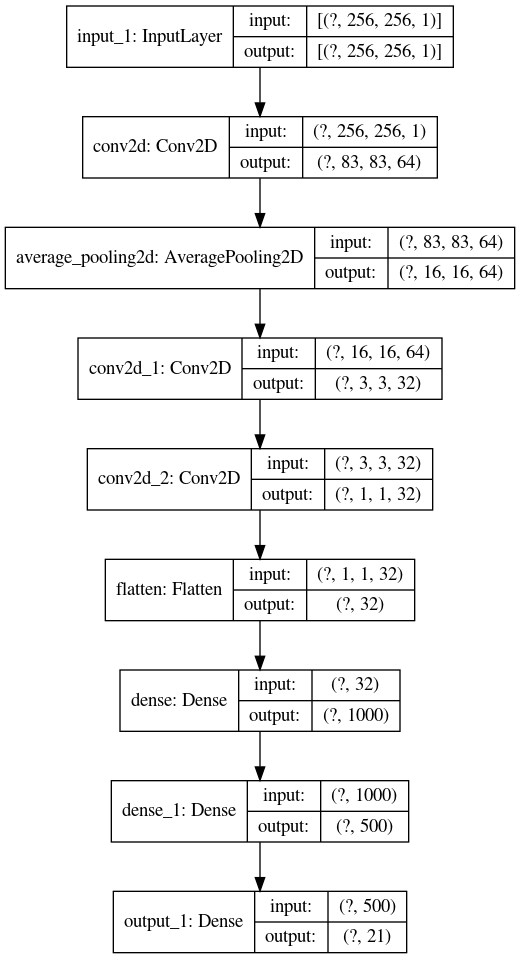

In [24]:
model = TERL()
# summarize layers
print(model.summary())
tf.keras.utils.plot_model(model, show_shapes=True)

In [25]:
one_hot_labels_train = tf.keras.utils.to_categorical(Y_train, num_classes=21)
one_hot_labels_validation = tf.keras.utils.to_categorical(Y_dev, num_classes=21)
one_hot_labels_test = tf.keras.utils.to_categorical(Y_test, num_classes=21)

# Fit the model
epochs = 100
train(model, X_train, one_hot_labels_train, X_dev, one_hot_labels_validation, X_test, one_hot_labels_test, 128, epochs, "TERL")
Final_Results_Test(log_Dir) 

Epoch 1/100
421/421 [==============================] - 8s 18ms/step - loss: 1.1238 - f1_m: 0.5718 - val_loss: 0.6688 - val_f1_m: 0.7626
Epoch 2/100
421/421 [==============================] - 7s 18ms/step - loss: 0.5597 - f1_m: 0.8064 - val_loss: 0.4843 - val_f1_m: 0.8415
Epoch 3/100
421/421 [==============================] - 7s 18ms/step - loss: 0.4161 - f1_m: 0.8624 - val_loss: 0.3950 - val_f1_m: 0.8769
Epoch 4/100
421/421 [==============================] - 7s 18ms/step - loss: 0.3482 - f1_m: 0.8859 - val_loss: 0.3475 - val_f1_m: 0.8886
Epoch 5/100
421/421 [==============================] - 7s 18ms/step - loss: 0.2902 - f1_m: 0.9072 - val_loss: 0.3233 - val_f1_m: 0.8998
Epoch 6/100
421/421 [==============================] - 7s 18ms/step - loss: 0.2489 - f1_m: 0.9208 - val_loss: 0.2780 - val_f1_m: 0.9158
Epoch 7/100
421/421 [==============================] - 7s 18ms/step - loss: 0.2230 - f1_m: 0.9293 - val_loss: 0.2544 - val_f1_m: 0.9241
Epoch 8/100
421/421 [===========================

Epoch 61/100
421/421 [==============================] - 7s 18ms/step - loss: 0.0141 - f1_m: 0.9953 - val_loss: 0.4596 - val_f1_m: 0.9236
Epoch 62/100
421/421 [==============================] - 8s 18ms/step - loss: 0.0153 - f1_m: 0.9948 - val_loss: 0.5444 - val_f1_m: 0.9215
Epoch 63/100
421/421 [==============================] - 7s 18ms/step - loss: 0.0231 - f1_m: 0.9922 - val_loss: 0.3841 - val_f1_m: 0.9363
Epoch 64/100
421/421 [==============================] - 7s 18ms/step - loss: 0.0131 - f1_m: 0.9955 - val_loss: 0.4352 - val_f1_m: 0.9337
Epoch 65/100
421/421 [==============================] - 7s 18ms/step - loss: 0.0112 - f1_m: 0.9965 - val_loss: 0.4162 - val_f1_m: 0.9377
Epoch 66/100
421/421 [==============================] - 7s 18ms/step - loss: 0.0204 - f1_m: 0.9935 - val_loss: 0.4241 - val_f1_m: 0.9372
Epoch 67/100
421/421 [==============================] - 7s 18ms/step - loss: 0.0144 - f1_m: 0.9953 - val_loss: 0.4388 - val_f1_m: 0.9301
Epoch 68/100
421/421 [===================

Loss=0.3283 y F1-Score=0.9378

saved-model-047-0.9354.hdf5
Loss=0.3062 y F1-Score=0.9432

saved-model-048-0.9342.hdf5
Loss=0.3251 y F1-Score=0.9418

saved-model-049-0.9324.hdf5
Loss=0.3367 y F1-Score=0.9395

saved-model-050-0.9376.hdf5
Loss=0.3388 y F1-Score=0.9429

saved-model-051-0.9349.hdf5
Loss=0.3390 y F1-Score=0.9403

saved-model-052-0.9296.hdf5
Loss=0.3525 y F1-Score=0.9376

saved-model-053-0.9369.hdf5
Loss=0.3447 y F1-Score=0.9443

saved-model-054-0.9323.hdf5
Loss=0.3627 y F1-Score=0.9377

saved-model-055-0.9304.hdf5
Loss=0.3747 y F1-Score=0.9363

saved-model-056-0.9346.hdf5
Loss=0.3273 y F1-Score=0.9415

saved-model-057-0.9345.hdf5
Loss=0.3456 y F1-Score=0.9410

saved-model-058-0.9356.hdf5
Loss=0.3362 y F1-Score=0.9411

saved-model-059-0.9235.hdf5
Loss=0.4259 y F1-Score=0.9307

saved-model-060-0.9309.hdf5
Loss=0.3396 y F1-Score=0.9407

saved-model-061-0.9236.hdf5
Loss=0.3960 y F1-Score=0.9284

saved-model-062-0.9215.hdf5
Loss=0.4847 y F1-Score=0.9260

saved-model-063-0.9363.hd

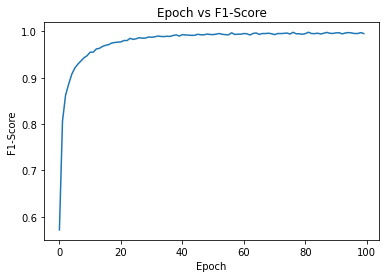

Test F1-Score 0.9472187161445618, Época:17

Test F1-Score 0.9470279812812805, Época:99

Test F1-Score 0.9469473361968994, Época:19

Test F1-Score 0.9445780515670776, Época:12

Test F1-Score 0.9444183111190796, Época:29


Train F1-Score 0.9980969429016113, Época:82

Train F1-Score 0.9979583024978638, Época:77

Train F1-Score 0.9976984262466431, Época:88

Train F1-Score 0.9973439574241638, Época:95

Train F1-Score 0.9972513318061829, Época:99


Validation F1-Score 0.9427253007888794, Época:19

Validation F1-Score 0.9401288032531738, Época:99

Validation F1-Score 0.9398017525672913, Época:24

Validation F1-Score 0.9397090673446655, Época:80

Validation F1-Score 0.9387297630310059, Época:17



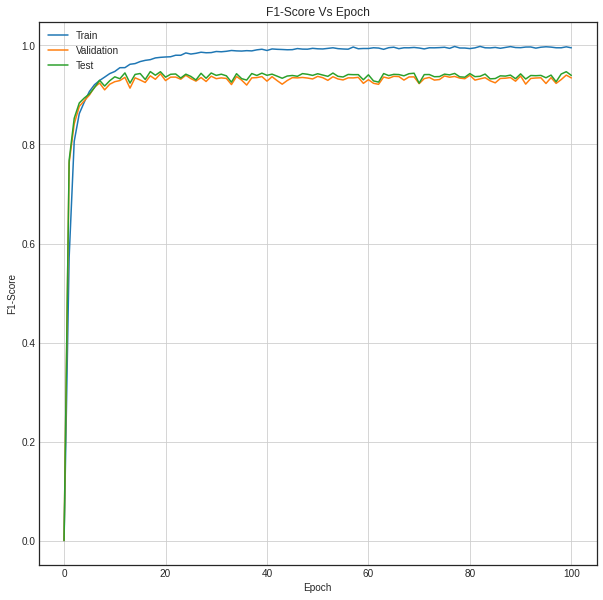

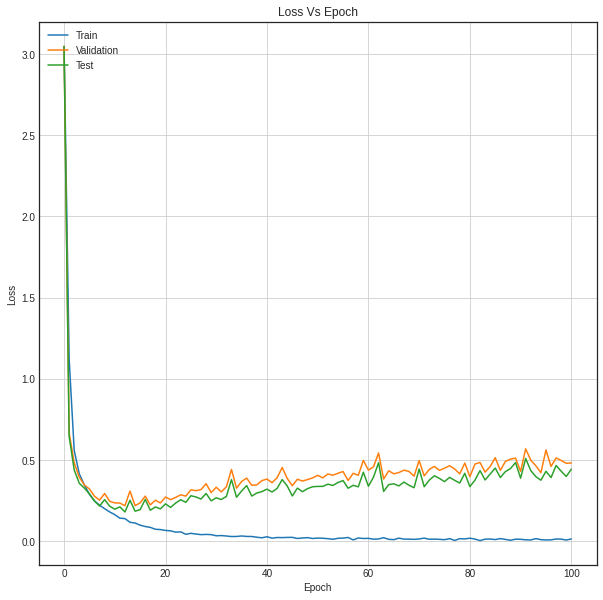

In [26]:
# plot metrics
plt.plot(history.history['f1_m'])
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('Epoch vs F1-Score')
plt.show()

#GRÁFICOS DE LAS TRES CURVAS TRAIN TEST Y VALIDACIÓN
graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID)


Baseline Error train: 0.22%
Baseline Error dev: 6.56%
Baseline Error test: 6.05%
Accuracy: 0.9977527672535473
F1 score: 0.9977519047555908
Recall: 0.9977527672535473
Precision: 0.9977665891462332

 clasification report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00      9563
           3       1.00      0.99      0.99      1158
           4       1.00      1.00      1.00      1481
           8       0.97      1.00      0.99        71
           9       0.99      1.00      1.00      2896
          12       1.00      1.00      1.00      5006
          13       1.00      1.00      1.00      2465
          14       1.00      0.98      0.99      1717
          16       0.98      1.00      0.99       434
          17       0.99      1.00      1.00      3605
          18       1.00      1.00      1.00      8282
          19       1.00      1.00      1.00      2765
          20       1.00      1.00      1.00     14401

    accuracy         

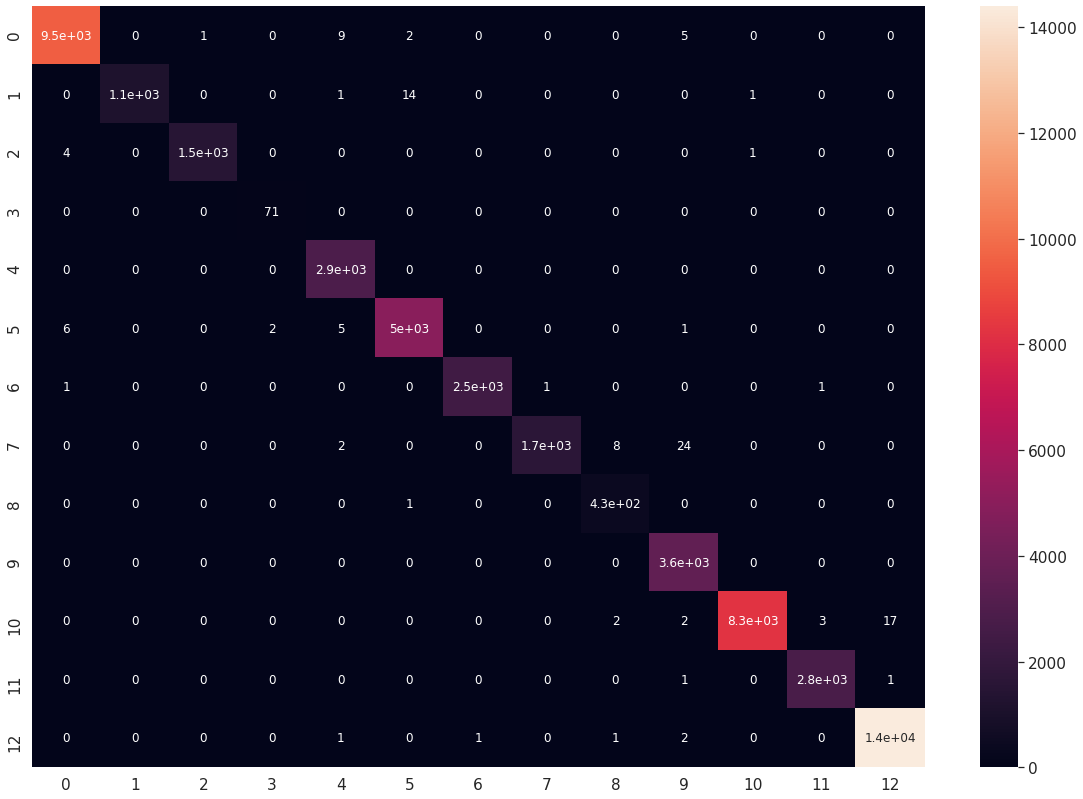

Accuracy: 0.9335809806835067
F1 score: 0.933647185874786
Recall: 0.9335809806835067
Precision: 0.9349746436297938

 clasification report:
               precision    recall  f1-score   support

           1       0.97      0.96      0.96      1248
           3       0.94      0.76      0.84       155
           4       0.90      0.84      0.87       180
           8       0.20      0.33      0.25         6
           9       0.84      0.95      0.89       341
          12       0.86      0.85      0.85       599
          13       0.93      0.94      0.93       340
          14       0.87      0.79      0.83       218
          16       0.67      0.79      0.73        57
          17       0.91      0.97      0.94       430
          18       0.96      0.94      0.95      1055
          19       0.92      0.91      0.91       362
          20       0.98      0.99      0.98      1739

    accuracy                           0.93      6730
   macro avg       0.84      0.85      0.84      

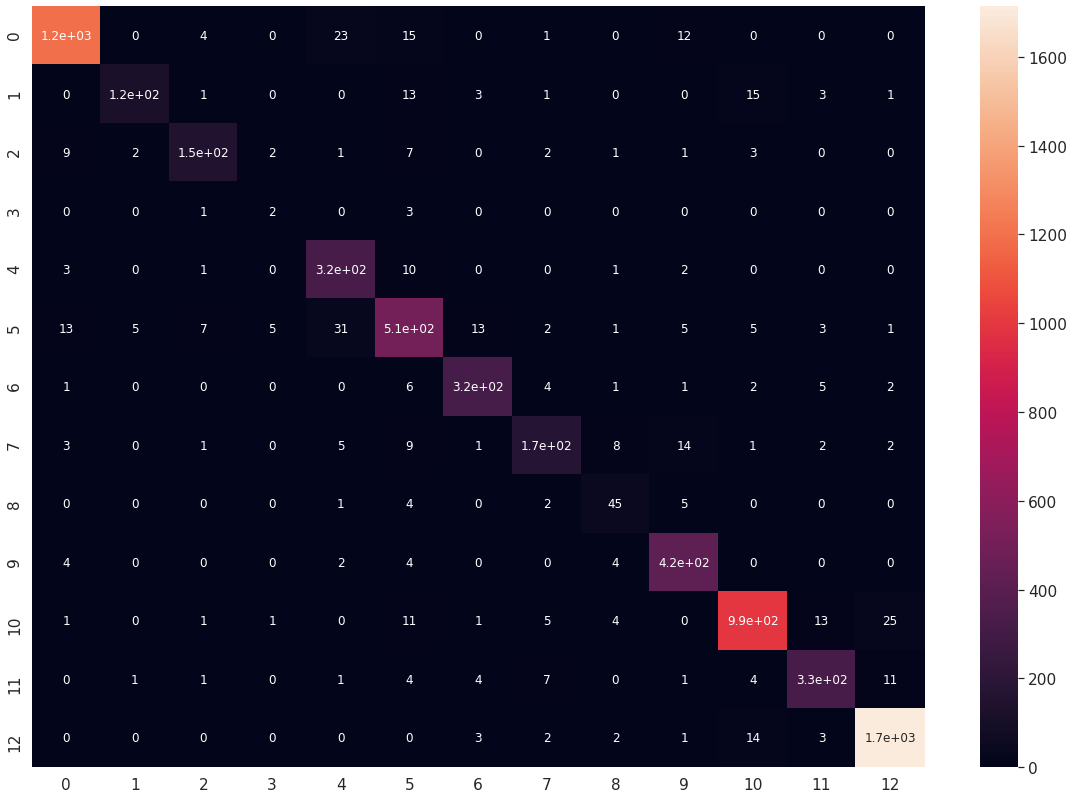

Accuracy: 0.9389392363690388
F1 score: 0.9388041852197467
Recall: 0.9389392363690388
Precision: 0.9405398627471099

 clasification report:
               precision    recall  f1-score   support

           1       0.98      0.96      0.97      1220
           3       0.93      0.73      0.82       145
           4       0.91      0.87      0.89       166
           8       0.50      0.57      0.53         7
           9       0.84      0.95      0.89       319
          12       0.83      0.89      0.86       575
          13       0.95      0.92      0.94       325
          14       0.94      0.76      0.84       201
          16       0.80      0.81      0.80        58
          17       0.93      0.98      0.96       497
          18       0.97      0.94      0.95      1059
          19       0.89      0.92      0.91       372
          20       0.97      0.98      0.98      1787

    accuracy                           0.94      6731
   macro avg       0.88      0.87      0.87     

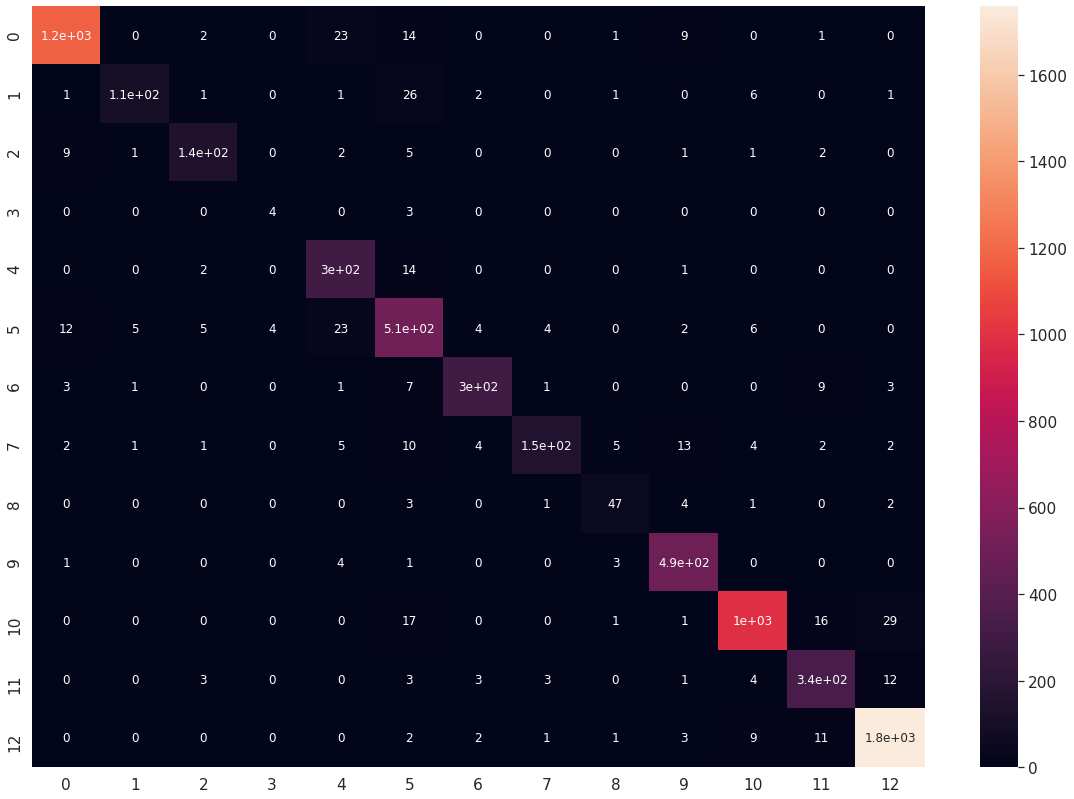

In [27]:
scores = model.evaluate(X_train, one_hot_labels_train, verbose=0)
print("Baseline Error train: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_dev, one_hot_labels_validation, verbose=0)
print("Baseline Error dev: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_test, one_hot_labels_test, verbose=0)
print("Baseline Error test: %.2f%%" % (100-scores[1]*100))

predictions = model.predict(X_train)

metrics(Y_train, [argmax(x) for x in predictions])

predictions = model.predict(X_dev)

metrics(Y_dev, [argmax(x) for x in predictions])

predictions = model.predict(X_test)

metrics(Y_test, [argmax(x) for x in predictions])